<a href="https://colab.research.google.com/github/Mathking1/ST456-Assignment1/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

# deep learning modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras import regularizers

# data preprocessing
from keras.utils import to_categorical

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Plot the confusion matrix of the classification task

# actual: true labels, given as a list of numerical values from 0 to num_classes - 1 (not one-hot encoded)
# predicted: predictions, given as a list of numerical values from 0 to num_classes - 1 (not one-hot encoded)
# labels: list of strings with the name of the classes

def plot_confusion_matrix(actual, predicted, labels):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(8, 8)})
  sns.set(font_scale=1.4)
  ax.set_xlabel('Predicted class')
  ax.set_ylabel('Actual class')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [4]:
# Per class, extract the indexes of correctly and uncorrectly predicted data points

# model: name of the model
# x_train: training data
# ind_class: for which class do you want to observe the wrong predictions? Give it as a numeric value, not a string

def ind_correct_uncorrect(model, x_train, ind_class):
  ind = np.where(np.argmax(y_train, axis=1) == ind_class)[0]
  ind_correct = []
  ind_uncorrect = []
  preds = model.predict(x_train[ind], verbose=0)
  for i in range(len(ind)):
    if np.argmax(preds[i]) == np.argmax(y_train[ind[i]]):
      ind_correct.append(ind[i])
    else:
      ind_uncorrect.append(ind[i])
  return ind_correct, ind_uncorrect

In [5]:
# Per class, plot a given number (i_max * j_max) of spectrograms

# i_max: number of rows of subplots
# j_max: number of columns of subplots
# x_train: training data
# ind_plot: indexes of the data points that you want to plot

def plot_spectrograms(i_max, j_max, x_train, ind_plot):
  fig, axs = plt.subplots(i_max, j_max, figsize=plt.figaspect(0.5))
  for i in range(i_max):
    for j in range(j_max):
      ind = ind_plot[i*j_max+j]
      axs[i, j].imshow(x_train[ind])
      axs[i, j].grid(False)
  fig.show()

In [6]:
# Per class, print the predictions of those points that were wrongly classified

# model: name of the model
# x_train: training data
# y_train: training labels, one hot encoded
# ind_wrong: indexes of wrongly predicted points
# ind_class: for which class do you want to observe the wrong predictions? Give it as a numeric value, not a string
# labels: list of strings with the name of the classes

def print_wrong_prediction(model, x_train, y_train, ind_wrong, ind_class, labels):
  print('Wrongly predicted points for true class', labels[ind_class])
  for i in range(len(ind_wrong)):
    preds = model.predict(tf.expand_dims(x_train[ind_wrong[i]], axis=0), verbose=0)
    if np.argmax(preds) != np.argmax(y_train[ind_wrong[i]]):
      print('predicted class is', labels[np.argmax(preds)])

In [7]:
# Compute Grad-CAM heatmap for a given data point and a hidden layer

# imag_array: image (represented as array) on which the heatmap will be produced
# model: name of the model
# layer_name: name of the layer on which the heatmap will be computed

def make_gradcam_heatmap(img_array, model, layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [8]:
# Per class, plot a given number (i_max * j_max) of Grad-CAM heatmaps

# i_max: number of rows of subplots
# j_max: number of columns of subplots
# x_train: training data
# ind: indexes of the wrongly predicted data for that class
# model: name of model
# layer_name: name of layer on which to compute Grad-CAM

def plot_gradcam_spectrogram(i_max, j_max, x_train, ind, model, layer_name):
  fig, axs = plt.subplots(i_max, j_max, figsize=plt.figaspect(0.5))
  for i in range(i_max):
    for j in range(j_max):
      ind_ = ind[i*j_max+j]
      heatmap = make_gradcam_heatmap(tf.expand_dims(x_train[ind_], axis=0), model, layer_name)
      axs[i, j].matshow(heatmap)
      axs[i, j].grid(False)
  fig.show()

# Loading

In [9]:
npzfile = np.load('/content/drive/MyDrive/ST456_WT2024_data_assign1.npz')

# features
x_train = npzfile['x_train']
x_val = npzfile['x_val']
x_test = npzfile['x_test']

# one hot encoded labels
y_train = npzfile['y_train']
y_val = npzfile['y_val']
y_test = npzfile['y_test']

# numerical labels
y_train_num = npzfile['y_train_num']
y_val_num = npzfile['y_val_num']
y_test_num = npzfile['y_test_num']

In [10]:
# the classes correspond to 4 music genres, in this order
classes = ['classical', 'disco', 'metal', 'rock']

In [11]:
# Model fit. Remember to use the CPU runtime and set the seed before:
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [ ]:
print(x_train.shape)

(3959, 80, 80, 1)


# P1

In [ ]:
model = Sequential()
model.add(keras.layers.Conv2D(4, (5,5), input_shape  = (80,80,1), padding= 'same', activation= 'relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(keras.layers.Conv2D(8, (5,5), padding= 'same', activation= 'relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(keras.layers.Conv2D(16, (5,5), padding= 'same', activation= 'relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dense(50,activation='relu',kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='sgd', loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 4)         104       
                                                                 
 max_pooling2d (MaxPooling2  (None, 40, 40, 4)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 8)         808       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 16)        3216      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 16)        0

# Question1
How many parameters does the model train? Before performing the training, do you expect this model to overfit? Which aspects would influence the overfitting (or not) of this model?

84382 parameters. Yes, I guess it may be overfit, because the architecture is reletively complex and the size of the data is small. What's more,there is only one regularization.

In [ ]:
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.14)

Epoch 1/20
107/107 [==============================] - 19s 153ms/step - loss: 2.0625 - accuracy: 0.4794 - val_loss: 1.9298 - val_accuracy: 0.5081
Epoch 2/20
107/107 [==============================] - 15s 143ms/step - loss: 1.6918 - accuracy: 0.6701 - val_loss: 1.9362 - val_accuracy: 0.6144
Epoch 3/20
107/107 [==============================] - 16s 148ms/step - loss: 1.5351 - accuracy: 0.7192 - val_loss: 1.5410 - val_accuracy: 0.7063
Epoch 4/20
107/107 [==============================] - 16s 147ms/step - loss: 1.4628 - accuracy: 0.7365 - val_loss: 1.4478 - val_accuracy: 0.7532
Epoch 5/20
107/107 [==============================] - 16s 147ms/step - loss: 1.3770 - accuracy: 0.7644 - val_loss: 1.3996 - val_accuracy: 0.7622
Epoch 6/20
107/107 [==============================] - 16s 152ms/step - loss: 1.3115 - accuracy: 0.7800 - val_loss: 1.6673 - val_accuracy: 0.6450
Epoch 7/20
107/107 [==============================] - 18s 165ms/step - loss: 1.2458 - accuracy: 0.7941 - val_loss: 1.2484 - val_ac

In [ ]:
model.save_weights('/content/drive/MyDrive/checkpoints/checkpoints_Assignment1_model')

In [ ]:
# # we can call back the model by downloading the saved checkpoint

# # first we need to re-instantiate the same model
#model = Sequential()
#model.add(keras.layers.Conv2D(4, (5,5), input_shape  = (80,80,1), padding= 'same', activation= 'relu'))
#model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
#model.add(keras.layers.Conv2D(8, (5,5), padding= 'same', activation= 'relu'))
#model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
#model.add(keras.layers.Conv2D(16, (5,5), padding= 'same', activation= 'relu'))
#model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
#model.add(Flatten())
#model.add(Dense(50,activation='relu',kernel_regularizer=keras.regularizers.l2(0.01)))
#model.add(Dense(4, activation='softmax'))



# # and compile it
#model.compile(optimizer='sgd', loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

# # then we load the weights
#model.load_weights('/content/drive/MyDrive/checkpoints/checkpoints_Assignment1_model')

# Question 2
Plot the loss function and the accuracy per epoch for the train and validation sets.

Text(0.5, 0.98, 'CNN - Conv2D + MaxPooling')

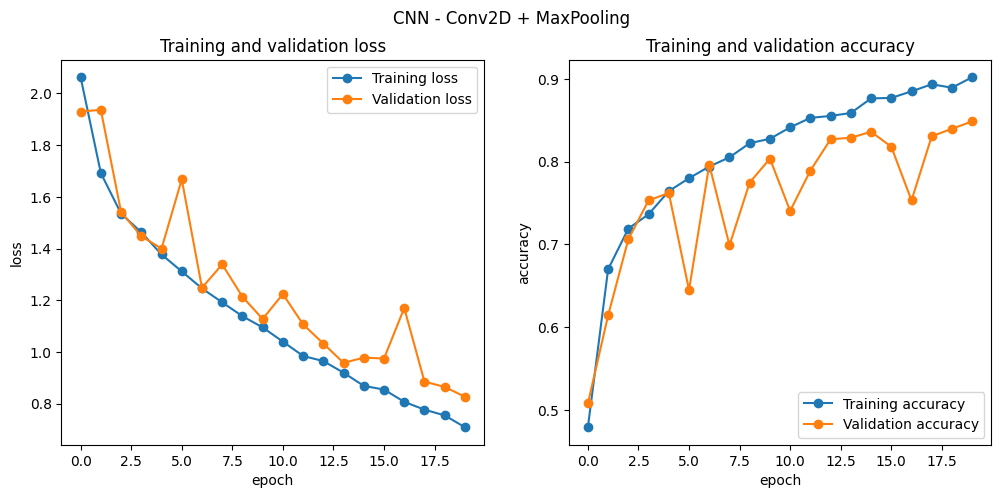

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(history.history['loss'],'-o', label='Training loss')
ax1.plot(history.history['val_loss'],'-o', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(loc='upper right')
ax2.plot(history.history['accuracy'],'-o', label='Training accuracy')
ax2.plot(history.history['val_accuracy'],'-o', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(loc='lower right')
f.suptitle('CNN - Conv2D + MaxPooling')

# Question 3
Which accuracy do you obtain on the test set?

0.878


In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

37/37 [==============================] - 3s 68ms/step - loss: 0.7805 - accuracy: 0.8788
Test accuracy: 0.8788396120071411


# Question 4
Using the function plot_confusion_matrix plot the confusion matrices of the classification task on the train set and test set. What do you observe from this metric? Which classes display more correct predictions? And wrong?

It's easy to confuse the identification of the two categories, disco and rock. Classical is the class display more correct predictions and disco is that wrong.

37/37 [==============================] - 2s 41ms/step


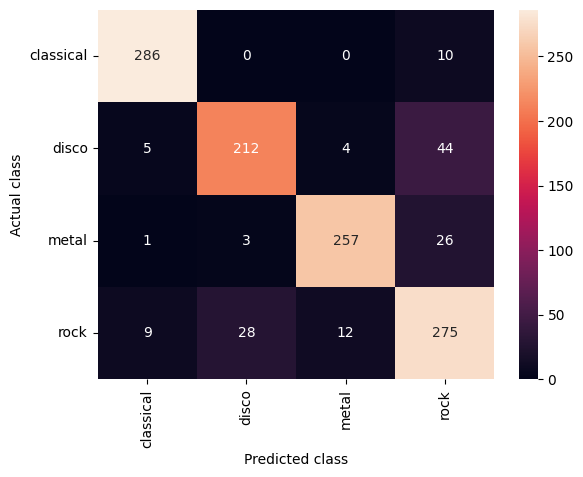

In [ ]:
y_prediction = model.predict(x_test)
y_prediction = np.argmax (y_prediction, axis = 1)
y_test1 = np.argmax (y_test, axis = 1)
result = plot_confusion_matrix(y_test_num, y_prediction , classes)

# Question5
Using the function ind_correct_uncorrect extract the indexes of the training data that were predicted correctly and incorrectly, per each class. For each music genre, perform the following steps:

 1.Using the function plot_spectrograms plot the 12 mel spectrograms of the first 6 data points which were predicted correctly and the first 6 which were predicted wrongly. Do you observe some differences among music genres?

Answer:The genres being identified as rock is dark, while the disco block is distinct with clear vertical line of chunking。The upper half of genre being identified as metal is bright, while its lower half is dark. That identified as rock is dark.


 2.Using the function print_wrong_prediction print the predicted classes of the first 6 data points which were predicted wrongly.


 3.Using the Grad-CAM method, implemented in the function plot_gradcam_spectrogram, print the heatmaps of the last pooling layer for the same 12 extracts (6 correct + 6 wrong). Comment on the heatmaps obtained. Do you observe differences among the heatmaps of different music genres? Can you understand why the model got some predictions wrong?

The heatmaps of music genres recognized as classical music are the brightest maps which means the model is most sensitive to the classical music. Therefore, the accuracy of classical music perdiction is the highest one.

The heatmaps of genres recognized as Disco is closed to that as Rock, so that two types of music is hard to identify.

The heatmaps of genres recognized as metal is the darkest one. Therefore, only a few of genres are wrongly threated as metal.

# Classical

In [ ]:
classical_idx_correct, classical_idx_wrong = ind_correct_uncorrect(model, x_train, 0)

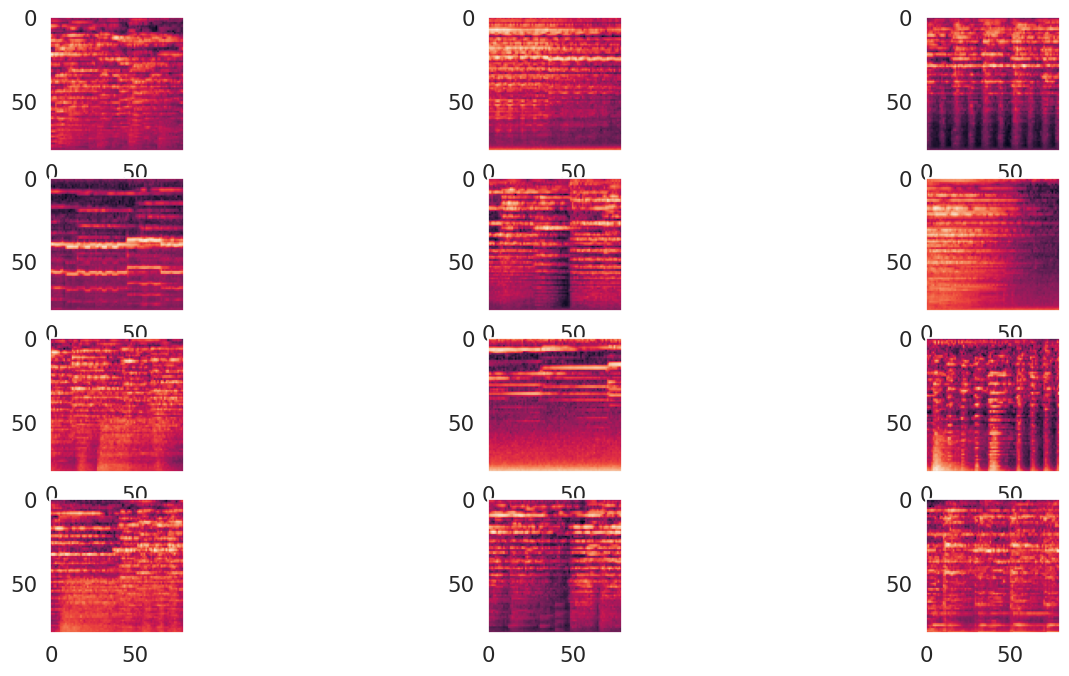

In [ ]:
classical_idx_correct_first6 = classical_idx_correct[:6]
classical_idx_wrong_first6 = classical_idx_wrong[:6]
classical_ind_plot = classical_idx_correct_first6 + classical_idx_wrong_first6
plot_spectrograms(4, 3, x_train, classical_ind_plot)

In [ ]:
print_wrong_prediction(model, x_train, y_train, classical_idx_wrong_first6, 0, classes)

Wrongly predicted points for true class classical
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is rock


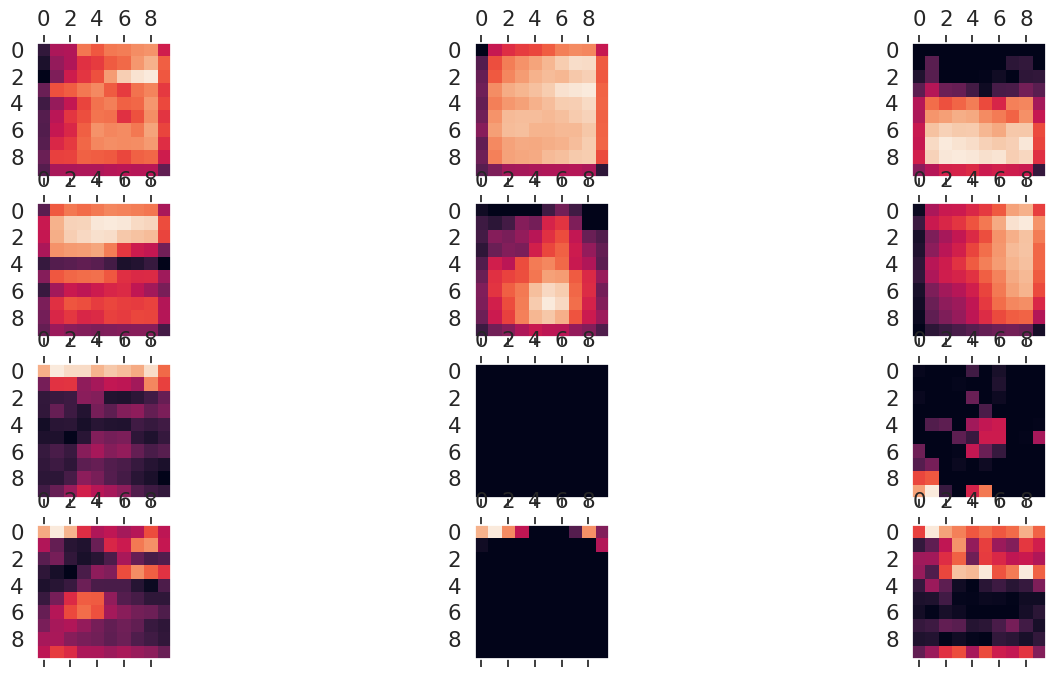

In [ ]:
plot_gradcam_spectrogram(4, 3, x_train, classical_ind_plot, model, 'max_pooling2d_2')

# Disco

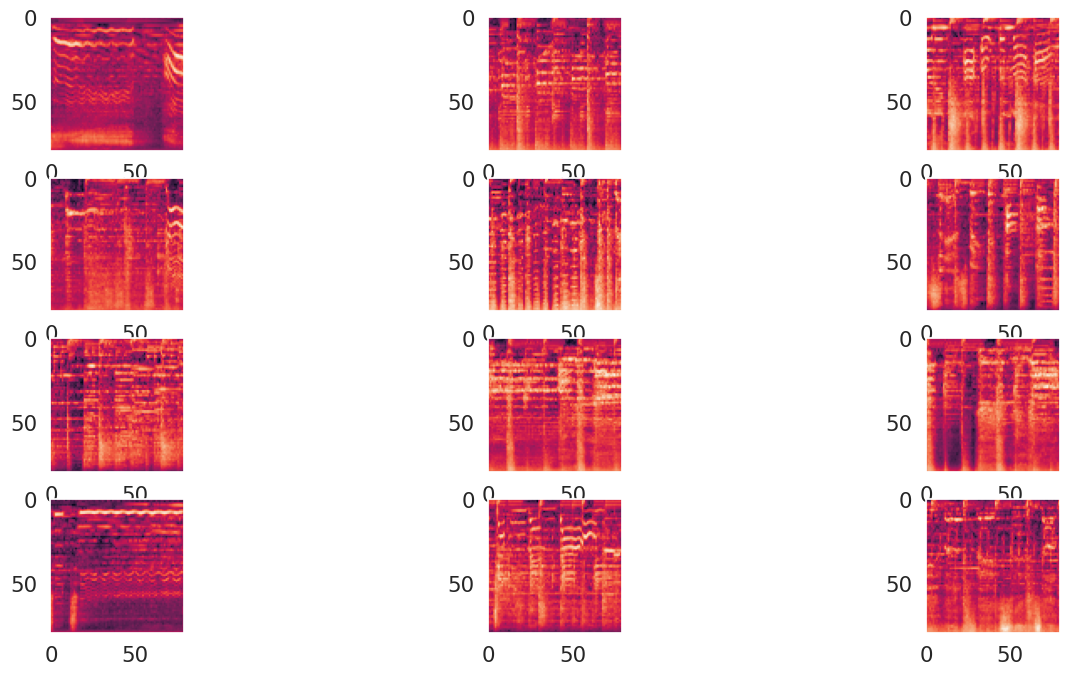

In [ ]:
disco_idx_correct, disco_idx_wrong = ind_correct_uncorrect(model, x_train, 1)

disco_idx_correct_first6 = disco_idx_correct[:6]
disco_idx_wrong_first6 = disco_idx_wrong[:6]
disco_ind_plot = disco_idx_correct_first6 + disco_idx_wrong_first6
plot_spectrograms(4, 3, x_train, disco_ind_plot)


Wrongly predicted points for true class disco
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is classical
predicted class is metal
predicted class is rock


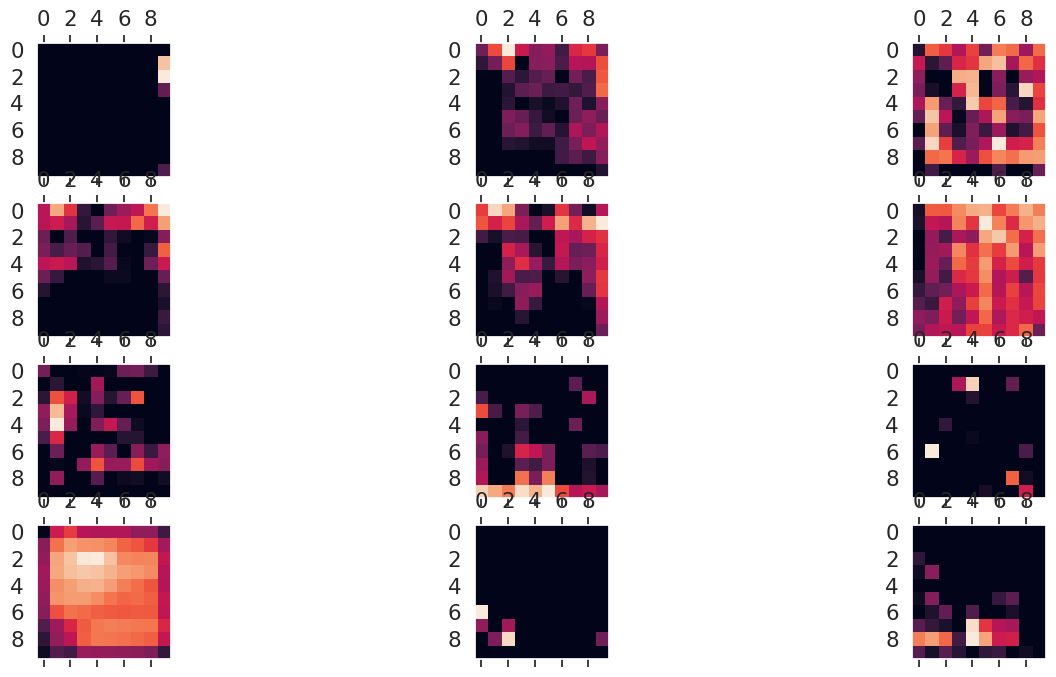

In [ ]:
print_wrong_prediction(model, x_train, y_train, disco_idx_wrong_first6, 1, classes)
plot_gradcam_spectrogram(4, 3, x_train, disco_ind_plot, model, 'max_pooling2d_2')

# Metal

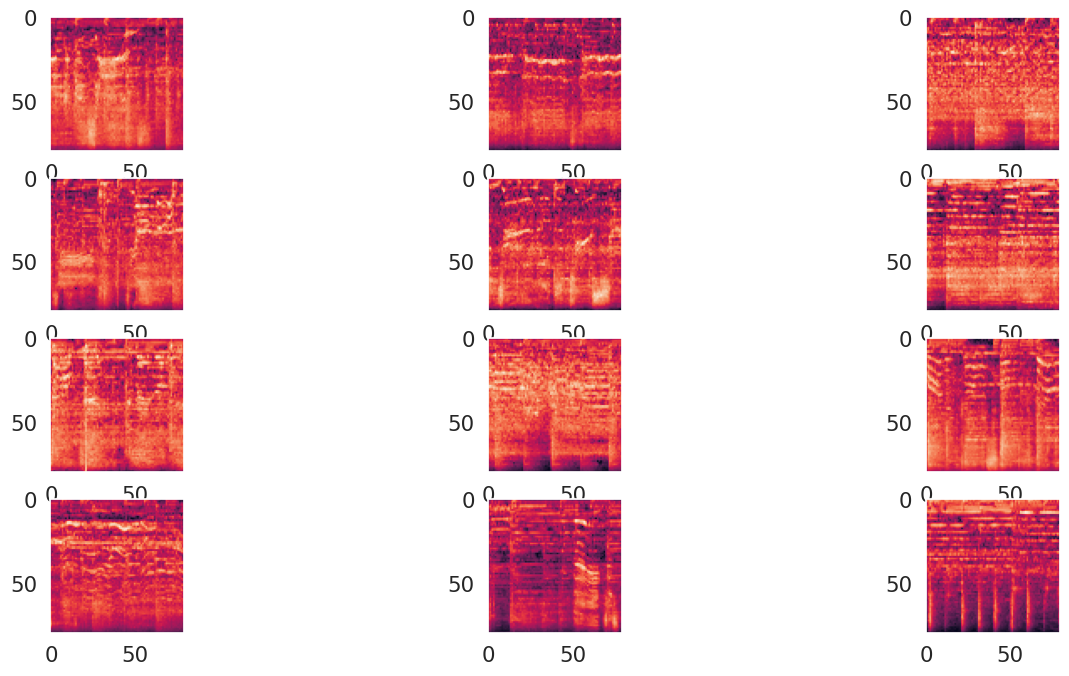

In [ ]:
metal_idx_correct, metal_idx_wrong = ind_correct_uncorrect(model, x_train, 2)

metal_idx_correct_first6 = metal_idx_correct[:6]
metal_idx_wrong_first6 = metal_idx_wrong[:6]
metal_ind_plot = metal_idx_correct_first6 + metal_idx_wrong_first6
plot_spectrograms(4, 3, x_train, metal_ind_plot)


Wrongly predicted points for true class metal
predicted class is rock
predicted class is rock
predicted class is disco
predicted class is rock
predicted class is rock
predicted class is rock


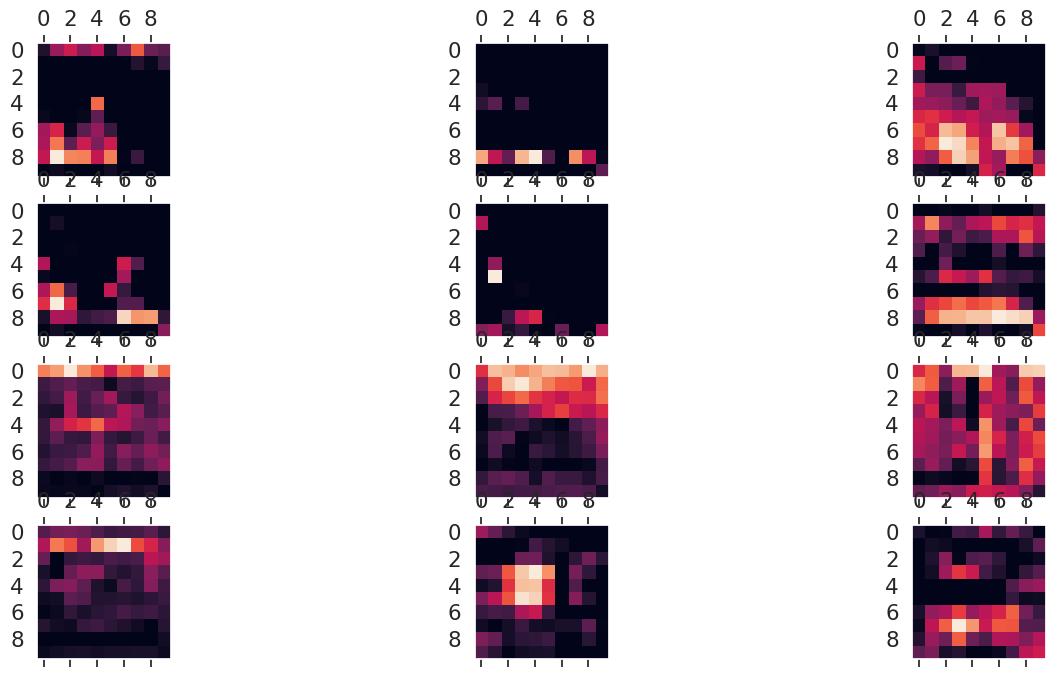

In [ ]:
print_wrong_prediction(model, x_train, y_train, metal_idx_wrong_first6, 2, classes)
plot_gradcam_spectrogram(4, 3, x_train, metal_ind_plot, model, 'max_pooling2d_2')

# Rock

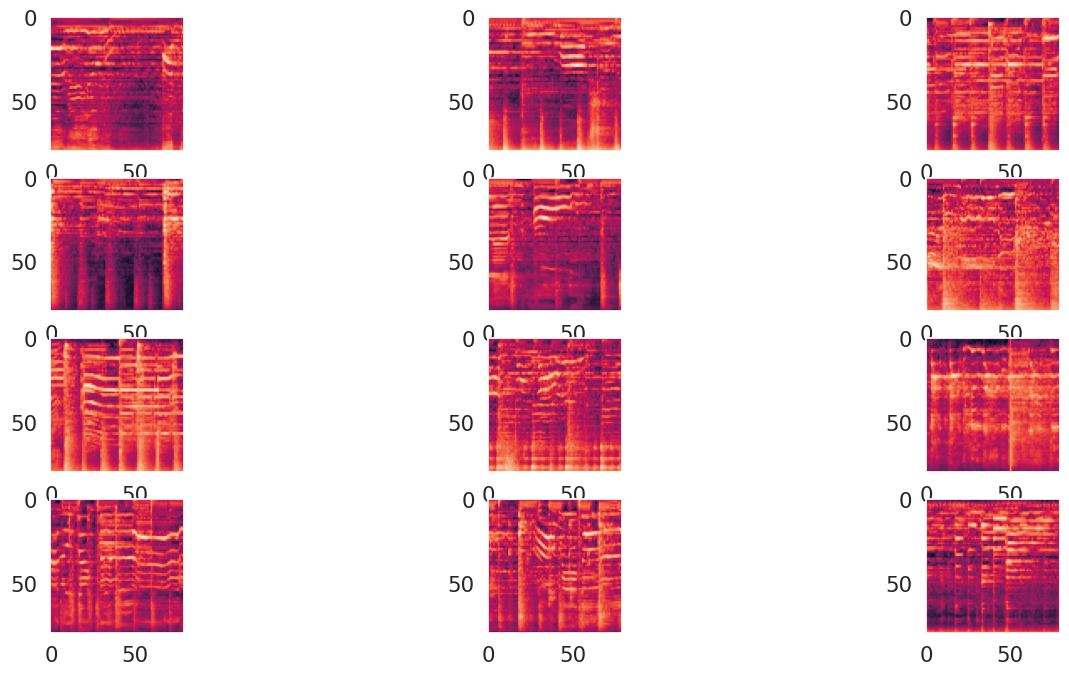

In [ ]:
rock_idx_correct, rock_idx_wrong = ind_correct_uncorrect(model, x_train, 3)

rock_idx_correct_first6 = rock_idx_correct[:6]
rock_idx_wrong_first6 = rock_idx_wrong[:6]
rock_ind_plot = rock_idx_correct_first6 + rock_idx_wrong_first6
plot_spectrograms(4, 3, x_train, rock_ind_plot)

Wrongly predicted points for true class metal
predicted class is disco
predicted class is disco
predicted class is disco
predicted class is disco
predicted class is disco
predicted class is classical


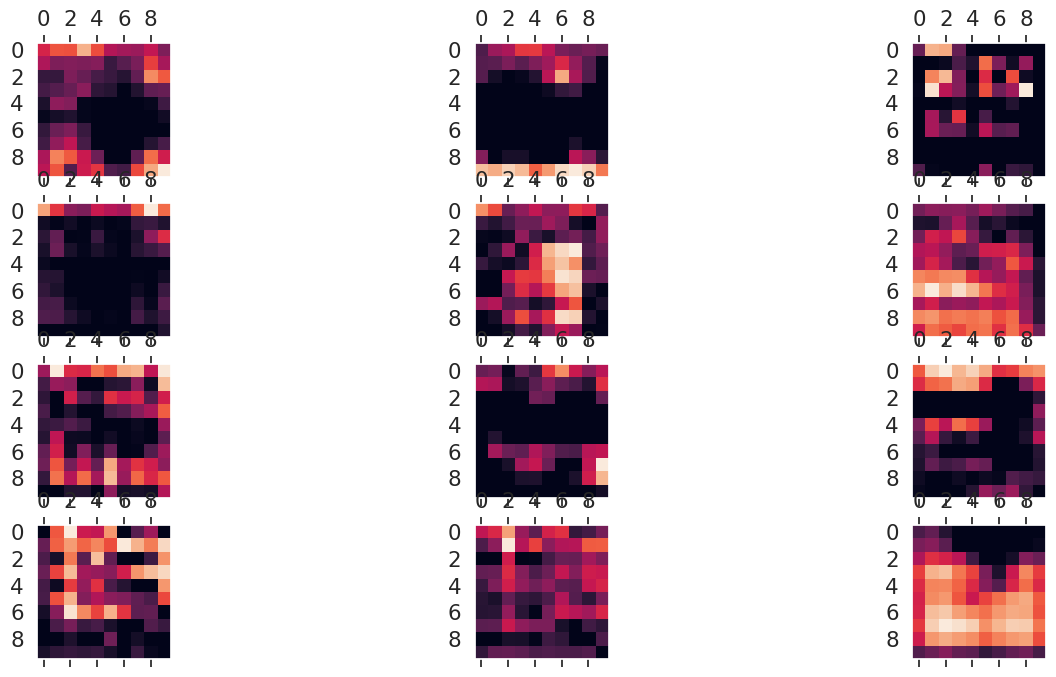

In [ ]:
print_wrong_prediction(model, x_train, y_train, rock_idx_wrong_first6, 2, classes)
plot_gradcam_spectrogram(4, 3, x_train, rock_ind_plot, model, 'max_pooling2d_2')

#Problem2 Explaination:
As the size of dataset is small, we can't build an architecture with too deep layers. Therefore, I reduce the depth. And we need to impliment some regularization techneques like L2 and dropout to avoid overfit. To increase the ability in extracting features, I reduce the kernal size of the first conv2d layer and increase the number of filters in each layers.

In [70]:

model2 = Sequential()
model2.add(keras.layers.Conv2D(12, (4,4), input_shape  = (80,80,1), padding= 'same', activation= 'relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model2.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
model2.add(Dropout(0.1))
model2.add(keras.layers.Conv1D(16, 5, padding= 'same', activation= 'relu', ))
model2.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))

model2.add(Dropout(0.4))
model2.add(Flatten())
model2.add(Dense(50,activation='relu',kernel_regularizer=keras.regularizers.l2(0.01)))
model2.add(Dense(4, activation='softmax'))

model2.compile(optimizer='sgd', loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
model2.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 80, 80, 12)        204       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 40, 40, 12)        0         
 ng2D)                                                           
                                                                 
 dropout_19 (Dropout)        (None, 40, 40, 12)        0         
                                                                 
 conv1d_14 (Conv1D)          (None, 40, 40, 16)        976       
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 20, 20, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 20, 20, 16)      

In [71]:
history2 = model2.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.14)

Epoch 1/20
107/107 [==============================] - 16s 138ms/step - loss: 1.9151 - accuracy: 0.6061 - val_loss: 1.7924 - val_accuracy: 0.6288
Epoch 2/20
107/107 [==============================] - 15s 141ms/step - loss: 1.6436 - accuracy: 0.7086 - val_loss: 1.5932 - val_accuracy: 0.7459
Epoch 3/20
107/107 [==============================] - 16s 146ms/step - loss: 1.5242 - accuracy: 0.7427 - val_loss: 1.5230 - val_accuracy: 0.7117
Epoch 4/20
107/107 [==============================] - 16s 147ms/step - loss: 1.4424 - accuracy: 0.7632 - val_loss: 1.4196 - val_accuracy: 0.7802
Epoch 5/20
107/107 [==============================] - 16s 154ms/step - loss: 1.3699 - accuracy: 0.7826 - val_loss: 1.4108 - val_accuracy: 0.7459
Epoch 6/20
107/107 [==============================] - 15s 141ms/step - loss: 1.2939 - accuracy: 0.8005 - val_loss: 1.7740 - val_accuracy: 0.6577
Epoch 7/20
107/107 [==============================] - 16s 146ms/step - loss: 1.2360 - accuracy: 0.8214 - val_loss: 1.2495 - val_ac

Text(0.5, 0.98, 'Nwe CNN - Conv2D + MaxPooling')

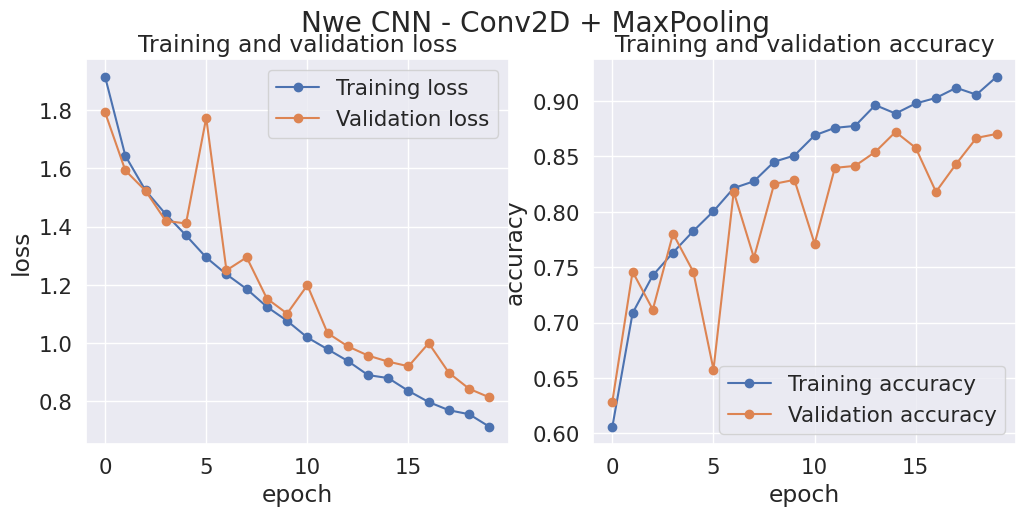

In [72]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(history2.history['loss'],'-o', label='Training loss')
ax1.plot(history2.history['val_loss'],'-o', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(loc='upper right')
ax2.plot(history2.history['accuracy'],'-o', label='Training accuracy')
ax2.plot(history2.history['val_accuracy'],'-o', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(loc='lower right')
f.suptitle('Nwe CNN - Conv2D + MaxPooling')

In [73]:
test_loss, test_acc = model2.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

37/37 [==============================] - 1s 38ms/step - loss: 0.7791 - accuracy: 0.8908
Test accuracy: 0.8907849788665771


37/37 [==============================] - 2s 37ms/step


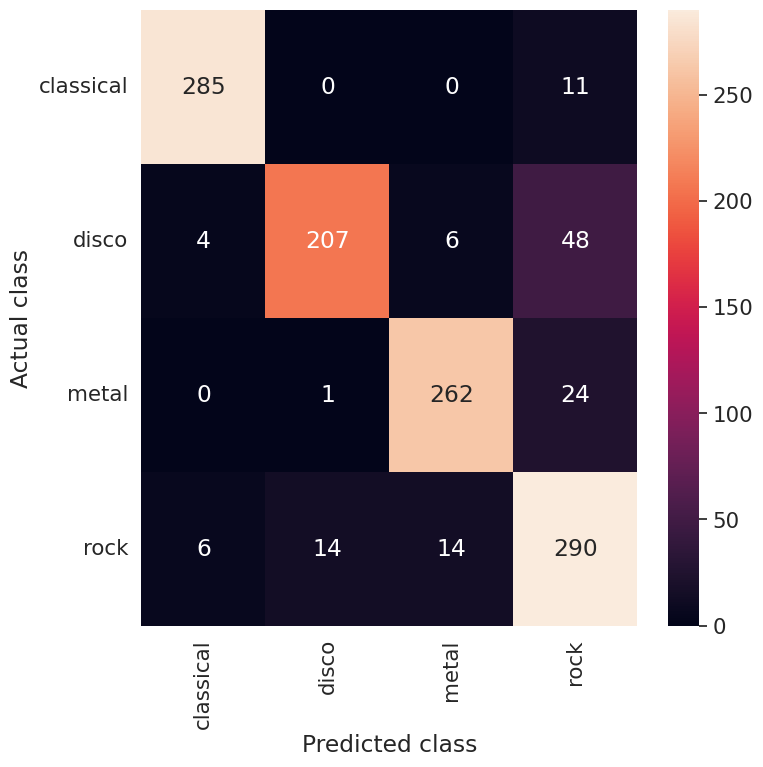

In [74]:
y_prediction = model2.predict(x_test)
y_prediction = np.argmax (y_prediction, axis = 1)
y_test1 = np.argmax (y_test, axis = 1)
plot_confusion_matrix(y_test1, y_prediction , classes)


124/124 [==============================] - 7s 53ms/step


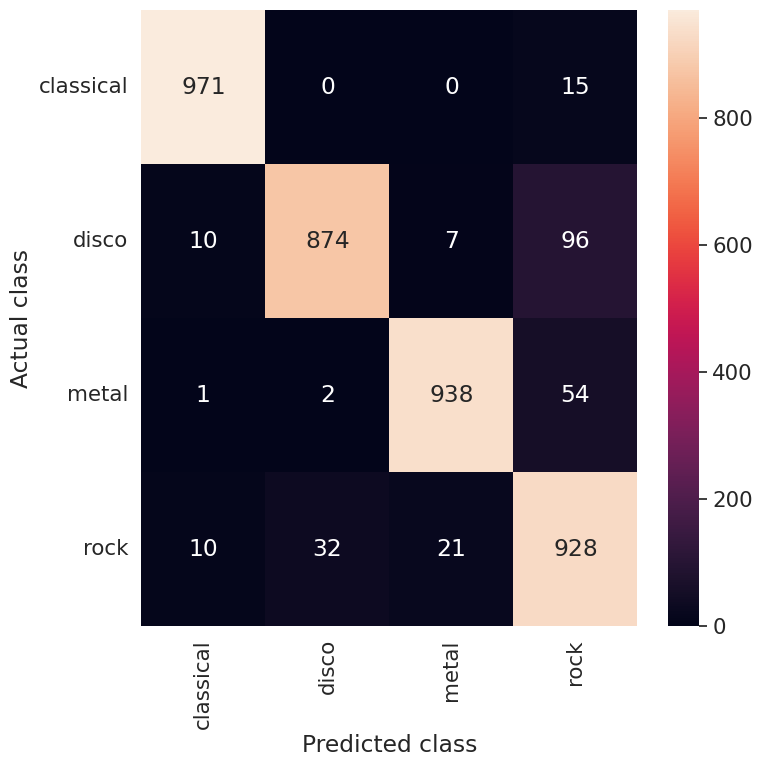

In [76]:
y_prediction2 = model2.predict(x_train)
y_prediction2 = np.argmax (y_prediction2, axis = 1)
plot_confusion_matrix(y_train_num, y_prediction2, classes)